# Table transformers for table detection and table structure recognition

[Source: Table transformers: inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Using_Table_Transformer_for_table_detection_and_table_structure_recognition.ipynb)


### Imports

In [1]:
from PIL import Image
from pdf2image import convert_from_path


### Load data

In [2]:
# specify the path to the PDF file
pdf_path = '../data/raw/CBD.PDF'

# convert the PDF pages to Pillow images using pdf2image
pdf_images = convert_from_path(pdf_path)

# save the images to disk
for i, image in enumerate(pdf_images):
    image.save(f'../data/assets/output_image_{i}.png', 'PNG')

/home/fxr/.local/share/virtualenvs/migrantes_desaparecidos_eeuu-0Fq2fihg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


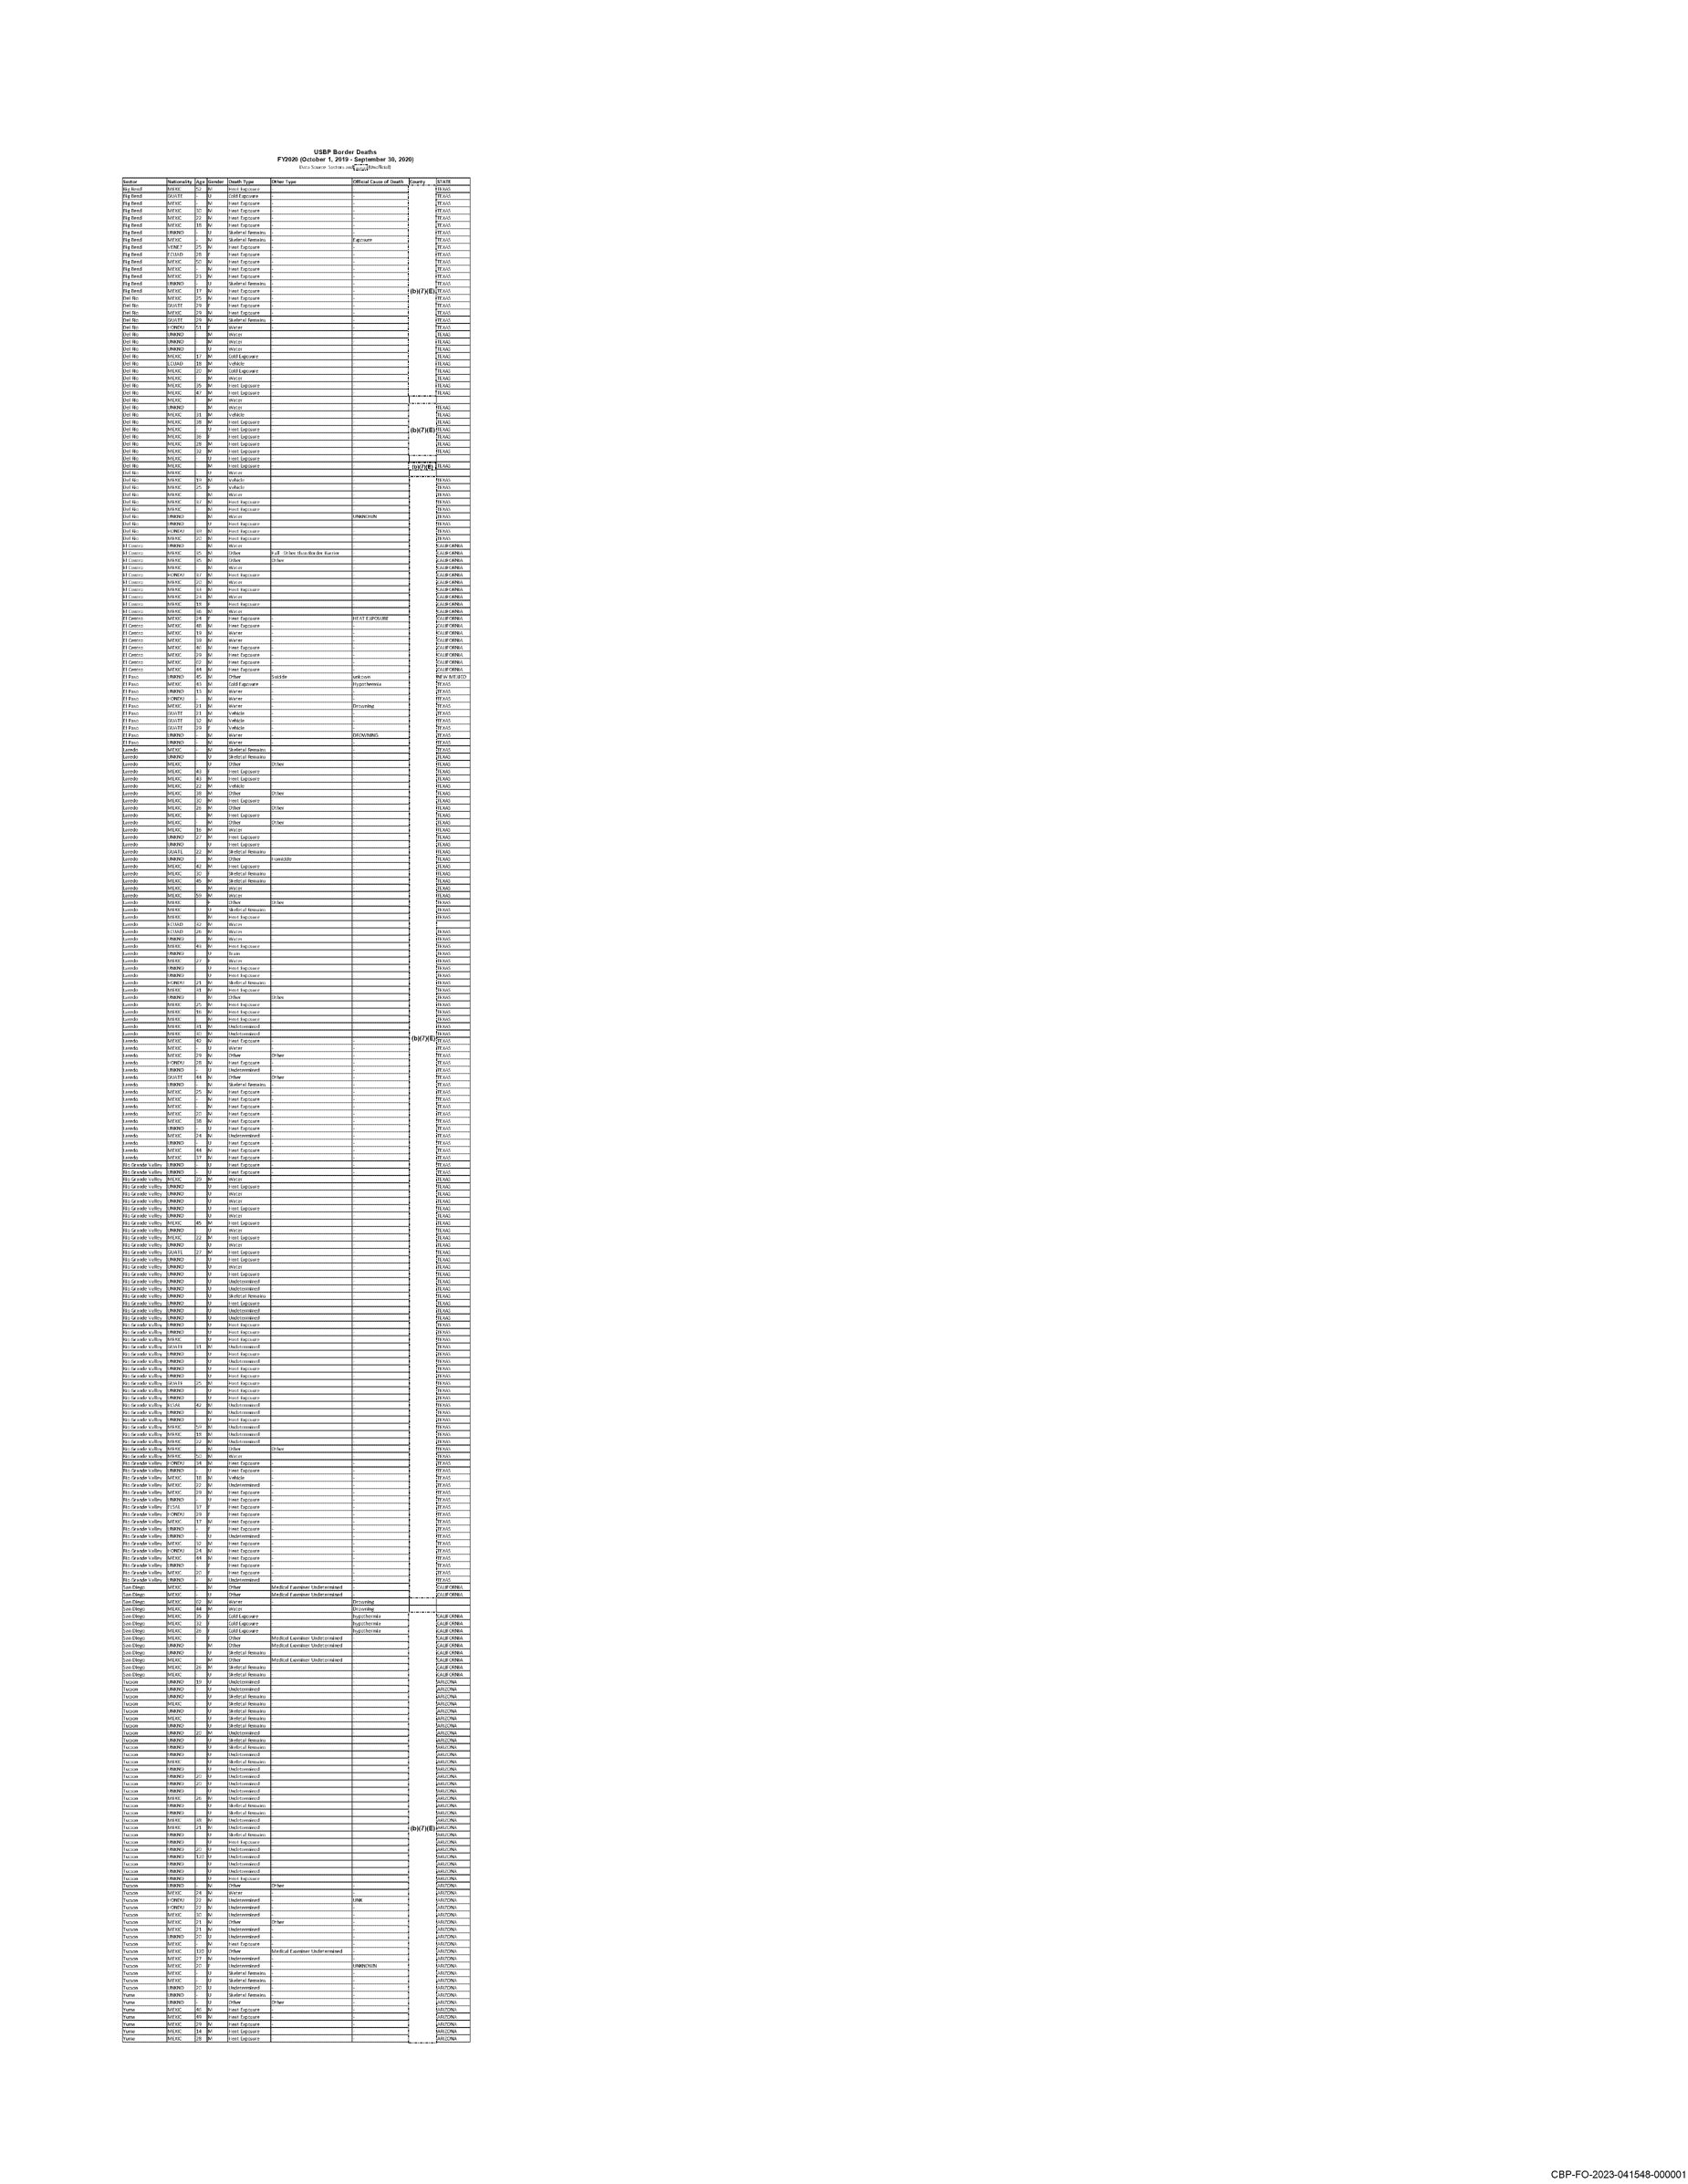

In [2]:
from huggingface_hub import hf_hub_download

# file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_pdf.png")
file_path = "../data/assets/output_image_0.png"
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))


### Prepare the image using DetrFeatureExtractor

[Source: DETR: inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/DETR_minimal_example_(with_DetrFeatureExtractor).ipynb)

In [5]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

/home/fxr/.local/share/virtualenvs/migrantes_desaparecidos_eeuu-0Fq2fihg/lib/python3.8/site-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


dict_keys(['pixel_values', 'pixel_mask'])

In [6]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 1035, 800])


In [7]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

In [8]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

In [10]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [11]:
# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

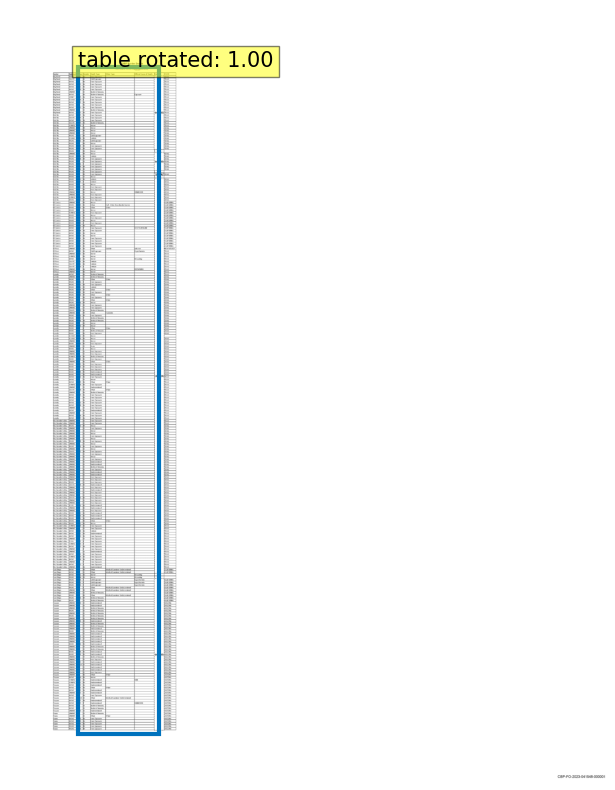

In [12]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

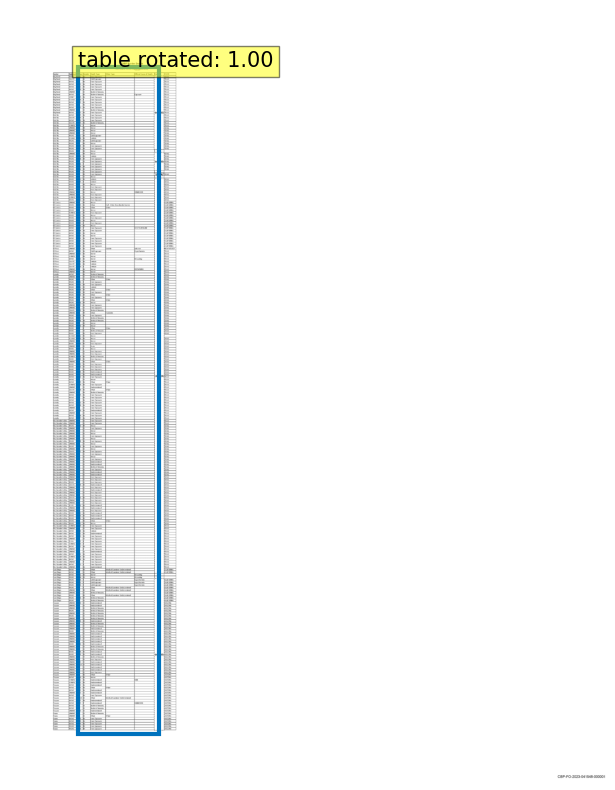

In [15]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [16]:
model.config.id2label

{0: 'table', 1: 'table rotated'}